In [11]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
###### %autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import xarray as xr
import pickle

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from statisticalDistributions import *
from plot1DInvLog import *
from importingData import *
from savingResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['thermoConstants', 'setEnv', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'dataFormat', 'savingResults', 'slicingAndSubsetting']


In [28]:
# Simulation root name
case = 'RCE'
Nxyz = '256x256x64'
Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
SSTs = (300,304)
states = 'disorganized','organized'
state_label = {'organized':'','disorganized':'-radhomo'}
colors = dict(zip(states,('#ff7f0e','#1f77b4')))

In [14]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

In [51]:
perc_ILQ_pr = {}
ranks_ILQ_pr = {}
ds_dict = {}
for SST in SSTs:
    perc_ILQ_pr[SST] = {}
    ranks_ILQ_pr[SST] = {}
    ds_dict[SST] = {}
    for state in states:
        expname = "TKE-SST%d%s-r1"%(SST,state_label[state])
        resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
        perc_ILQ_pr[SST][state] = pickle.load(open(os.path.join(resultsubdir,'percentiles_ILQ_pr.pickle'),'rb'))
        ranks_ILQ_pr[SST][state] = pickle.load(open(os.path.join(resultsubdir,'ranks_ILQ_pr.pickle'),'rb'))
        simname = "%s_%s"%(simroot,expname)
        simdir = os.path.join(archivedir,simname,'OUT_STAT')
        filename = "%s.nc"%(simname)
        ds_dict[SST][state] = xr.open_dataset(os.path.join(simdir,filename))


In [63]:
time_labels = np.array(list(perc_ILQ_pr[SSTs[0]][states[0]].keys()))
Ts = np.arange(240,2400,240)
dt = 10 # days
sT90 = slice(int(Ts[-1]-dt/2*24),int(Ts[-1]+dt/2*24))
t90 = time_labels[-1]ß

In [17]:
Qmax = 99.99
iQmax = indexOfRank(Qmax,ranks_ILQ_pr[SSTs[0]][states[0]][time_labels[0]])
sQ = slice(0,iQmax)
ranks = ranks_ILQ_pr[SSTs[0]][states[0]][time_labels[0]][sQ]

# Fractional change

## Extremes

In [47]:
figsubdir_fracchanges = os.path.join(figuredir,simroot,'fracchanges')
if not os.path.exists(figsubdir_fracchanges): os.makedirs(figsubdir_fracchanges)

In [39]:
fracchange_pr = {}
for state in states:
    fracchange_pr[state] = {}
    for t_lab in time_labels:
        fcpr = np.zeros((iQmax,))
        for i in range(iQmax):
            if perc_ILQ_pr[SSTs[0]][state][t_lab][i] == 0:
                fcpr[i] = np.nan
            else:
                fcpr[i] = (perc_ILQ_pr[SSTs[1]][state][t_lab][i]/perc_ILQ_pr[SSTs[0]][state][t_lab][i]-1)/(SSTs[1]-SSTs[0])*100
            fracchange_pr[state][t_lab] = fcpr

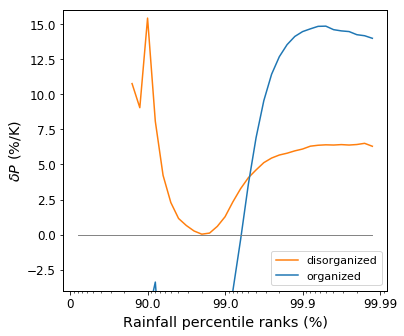

In [49]:
fig,ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_ylim((-4,16))
for state in states:
    addZeroLine(ax,ranks)
    subplotRanksILog(ax,ranks,
                     [fracchange_pr[state][t90]],
                     col=[colors[state]],
                     ltype=['-'],
                     labels=[state],transformX=state==states[-1])
#     ax.plot(ranks,fracchange_pr[state][t90])
ax.legend(fontsize=11)

ax.set_ylabel(r'$\delta P$ (%/K)')
ax.set_xlabel(r'Rainfall percentile ranks (%)')
plt.savefig(os.path.join(figsubdir_fracchanges,'frachange_pr_%s_%s.pdf'%('_'.join(states),'_'.join([str(s) for s in SSTs]))),
            bbox_layout='tight')

## Mean precipitation

In [66]:
print("- Fractional change in mean precipitation")
for state in states:
    fracchange_pr_m = (ds_dict[SSTs[1]][state].PREC.data[sT90].mean()/ds_dict[SSTs[0]][state].PREC.data[sT90].mean()\
                       -1)/(SSTs[1]-SSTs[0])*100
    print(state,"convection:",fracchange_pr_m)

- Fractional change in mean precipitation
disorganized convection: 3.53783071041
organized convection: 4.33506369591


In [68]:
# Test with energy budget